In [9]:
from selenium import webdriver
from selenium.webdriver.firefox.options import Options
options = Options()
options.binary_location = 'geckodriver'


In [10]:
import time
from urllib.request import Request, urlopen
from urllib.error import HTTPError

# Define la URL base
base_url = "https://www.infocasas.com.uy/alquiler/inmuebles/pagina"

# Número total de páginas
total_pages = 10

# Lista para almacenar el HTML de cada página
html_base = []

# Set the number of retries
max_retries = 3

# Set the initial delay between retries
retry_delay = 1

# Itera sobre todas las páginas
for page_number in range(1, total_pages + 1):
    # Construye la URL completa para la página actual
    url = f"{base_url}{page_number}"

    # This packages the request
    request = Request(url)

    # Retry the request for a maximum number of times
    for retry in range(max_retries):
        try:
            # Sends the request and catches the response: response
            response = urlopen(request)

            # Extract the response: html
            html = response.read()

            # Agrega el HTML al array html_data
            html_base.append(html)

            # Be polite and close the response!
            response.close()

            # Break out of the loop if the request is successful
            break

        except HTTPError as e:
            # Print the error message
            print(f"HTTP Error: {e.code} - {e.reason}")

            # Retry after a delay
            time.sleep(retry_delay)

            # Increase the delay for the next retry
            retry_delay *= 2

    else:
        # If all retries fail, print an error message
        print(f"Maximum number of retries reached for page {page_number}. Request failed.")



In [11]:
from bs4 import BeautifulSoup

# Create an empty array to store the processed HTML elements
sopita = []

# Loop through each html_code element
for html in html_base:
    soup = BeautifulSoup(html, 'lxml')

    sopita.append(soup)

In [12]:
    links_array = []

    for soup in sopita:
        links = soup.find_all('a', class_='lc-cardCover')
        links_array.extend(links)

In [13]:
urls = [link['href'] for link in links_array]
urls = [f"https://www.infocasas.com.uy{link}" for link in urls]

In [14]:
len(urls)

210

In [15]:
# Lista para almacenar el HTML de cada página
html_data = []

# Set the number of retries
max_retries = 3

# Set the initial delay between retries
retry_delay = 1

# Asume que `urls` es el arreglo que contiene las URLs completas para hacer las solicitudes
# urls = [...]

# Itera sobre todas las URLs en el arreglo
for index, url in enumerate(urls, start=1):
    # This packages the request
    request = Request(url)

    # Retry the request for a maximum number of times
    for retry in range(max_retries):
        try:
            # Sends the request and catches the response: response
            response = urlopen(request)

            # Extract the response: html
            html = response.read()

            # Agrega el HTML al array html_data
            html_data.append(html)

            # Be polite and close the response!
            response.close()

            # Break out of the loop if the request is successful
            break

        except HTTPError as e:
            # Print the error message
            print(f"HTTP Error: {e.code} - {e.reason} on page {index}")

            # Retry after a delay
            time.sleep(retry_delay)

            # Increase the delay for the next retry
            retry_delay *= 2

    else:
        # If all retries fail, print an error message
        print(f"Maximum number of retries reached for page {index}. Request failed.")


In [29]:
len(html_data)

210

In [30]:
prices = []
for html in html_data:
    price_element = BeautifulSoup(html, 'lxml').find('span', class_='ant-typography price')
    if price_element:
        price = price_element.text
        prices.append(price)
    else:
        prices.append('N/A')  # Add a placeholder value if the element is not found


In [31]:
gastos_list = []

for html in html_data:
    gastos_tags = BeautifulSoup(html, 'lxml').find_all('span', class_='ant-typography ant-typography-secondary commonExpenses')
    if gastos_tags:  # Verificar si hay elementos encontrados
        gastos_text = ''.join(tag.text for tag in gastos_tags)  # Unir el texto de todos los elementos encontrados
        gastos_list.append(gastos_text)
    else:
        gastos_list.append('0')  # Agregar '0' si no se encontraron elementos

In [91]:
html_data[2]

b'<!DOCTYPE html><html class="infocasas-theme" id="bodyTag" lang="es-UY"><head><link rel="preload" as="font" href="https://cdn2.infocasas.com.uy/web/5fdcaa52b06cf_infocdn__infocasas-regular.woff2" type="font/woff" crossorigin="anonymous"/><link rel="preload" as="font" href="https://cdn2.infocasas.com.uy/web/5fdcaa52af7c5_infocdn__infocasas-bold.woff2" type="font/woff" crossorigin="anonymous"/><meta charSet="utf-8"/><link rel="icon" href="https://cdn2.infocasas.com.uy/web/5ee376daa7764_infocdn__favicon.ico" type="image/x-icon"/><meta name="referrer" content="no-referrer-when-downgrade"/><meta http-equiv="Content-Type" content="text/html; charset=utf-8"/><meta name="author" content="InfoCasas"/><meta name="viewport" content="width=device-width, initial-scale=1.0, maximum-scale=1.0,user-scalable=0"/><title>ALQUILER POCITOS 1 DORM C/GGE. Ref #WF065B - infocasas.com.uy</title><link rel="canonical" href="https://www.infocasas.com.uy/alquiler-pocitos-1-dorm-cgge/190873492"/><meta name="descri

In [123]:
import json
from bs4 import BeautifulSoup

# Initialize an empty list to hold all technical sheets from all HTML contents
casas = []

# Loop through each HTML content in 'html_data'
for html_content in html_data:
    soup = BeautifulSoup(html_content, 'html.parser')
    script_tag = soup.find('script', {'id': '__NEXT_DATA__'})
    json_text = script_tag.string if script_tag else '{}'
    data = json.loads(json_text)
    
    # This checks if 'property_keys' can be found in the data
    if 'props' in data and 'pageProps' in data['props'] and 'apolloState' in data['props']['pageProps']:
        property_keys = [key for key in data['props']['pageProps']['apolloState'].keys() if key.startswith('Property:')]
        
        if property_keys:
            # Assuming there is at least one property key
            technical_sheet = data['props']['pageProps']['apolloState'][property_keys[0]].get('technicalSheet', [])
            
            # Process the technical sheet to your desired format here
            # For example, convert each item to a tuple of (text, value)
            formatted_technical_sheet_tuples = [(item['text'], item['value']) for item in technical_sheet]
            
            # Append the processed technical sheet for this HTML content to the all_technical_sheets list
            casas.append(formatted_technical_sheet_tuples)

In [124]:
for i in range(len(casas)):
    casas[i].append(('Precio', prices[i]))


In [125]:
import pandas as pd

# Suponiendo que casas es una lista de listas, donde cada sublista contiene tuplas (nombre, valor) que representan las características de una casa

# Crear un conjunto para almacenar todos los nombres de características encontrados en todas las casas
todos_los_nombres = set()
for casa in casas:
    for nombre, _ in casa:
        todos_los_nombres.add(nombre)

# Crear un diccionario para almacenar los valores de las características para cada casa
datos_dict = {}
for i, casa in enumerate(casas):
    casa_dict = dict(casa)
    datos_dict[i] = casa_dict

# Crear el DataFrame
df = pd.DataFrame.from_dict(datos_dict, orient='index')

# Ordenar las columnas por los nombres de características
df = df.reindex(sorted(todos_los_nombres), axis=1)

# Imprimir el DataFrame


In [126]:
df.drop('Contrato Mínimo', axis=1, inplace=True)
df.drop('Acepta mascotas', axis=1, inplace=True)



In [127]:
import numpy as np
df.head(3)


,Apartamentos por Pisos,Año de Construcción,Barrio Privado,Baños,Cantidad de Pisos,Disposición,Dormitorios,Estado,Garajes,Gastos Comunes,...,M² del terreno,M² edificados,Piso,Plantas,Precio,Referencia,Sobre,Tipo de Propiedad,Vivienda Social,Zona
0,NaN,,,4,NaN,No aplica,3,Buen estado,,NaN,...,1.000 m2,,NaN,,"U$S 4,200",Z6132A,No aplica,Casa,,La Barra
1,NaN,,,8,NaN,No aplica,6,Buen estado,,NaN,...,1.100 m2,300 m2,NaN,,"U$S 5,500",V8F603,No aplica,Casa,,La Barra
2,2,2017,,1,10,Al frente,1,Excelente estado,1,$ 5.600,...,,45 m2,9,1,"$ 32,000",WF065B,No aplica,Apartamento,,Pocitos


In [128]:
df['M² de terraza'] = df['M² de terraza'].str.extract('(\d+)').astype(float)
df['M² edificados'] = df['M² edificados'].str.extract('(\d+)').astype(float)
df['M² del terreno'] = df['M² del terreno'].str.extract('(\d+)').astype(float)


In [130]:
df['Precio'] = df['Precio'].str.replace('.', '')
df['Precio'] = df['Precio'].str.replace(',', '')

df[['Moneda', 'Monto']] = df['Precio'].str.split(' ', n=1, expand=True)
df['Monto'] = df['Monto'].astype(float)
df.drop('Precio', axis=1, inplace=True)



In [131]:
df.loc[df['Moneda'] == 'U$S', 'Monto'] *= 40


In [132]:
# Filtrar las observaciones según el rango especificado
df = df[(df['Monto'] <= 80000) & (df['Monto'] >= 1000)]

# Verificar la forma del DataFrame filtrado
print("Número de observaciones después de filtrar:", df.shape[0])

# Ahora el DataFrame original ha sido actualizado con las observaciones filtradas



Número de observaciones después de filtrar: 144


<Axes: xlabel='Moneda', ylabel='Monto'>

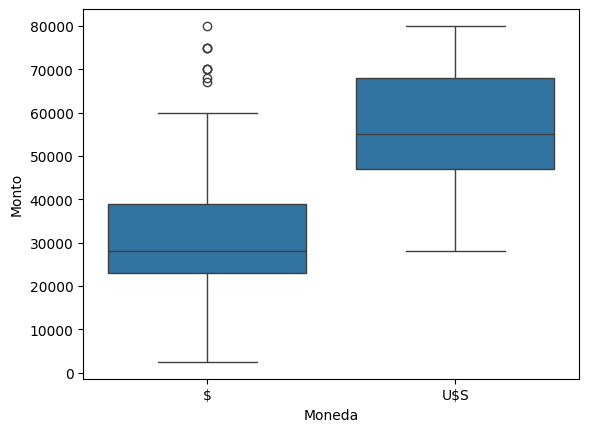

In [133]:
import seaborn as sns

sns.boxplot(x='Moneda', y='Monto', data=df)

<Axes: xlabel='Monto', ylabel='Count'>

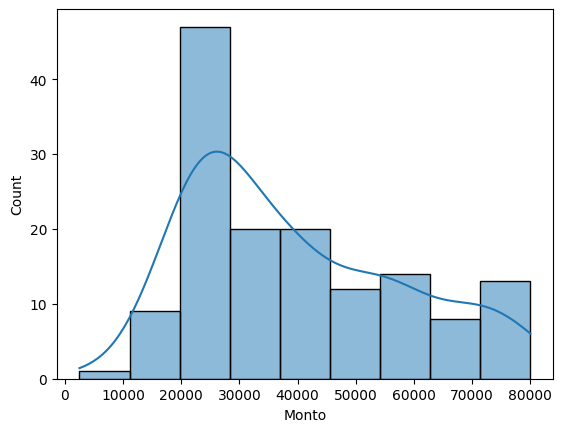

In [134]:
sns.histplot(df['Monto'], kde=True)

In [135]:
df['Año de Construcción'] = df['Año de Construcción'].replace('¡Preguntale!	', np.nan)
df['Año de Construcción'] = pd.to_numeric(df['Año de Construcción'], errors='coerce')


In [136]:
df['Baños'] = pd.to_numeric(df['Baños'], errors='coerce')
df['Dormitorios'] = pd.to_numeric(df['Dormitorios'], errors='coerce')


In [137]:
df['Garajes'] = df['Garajes'].replace('¡Preguntale!', np.nan)
df['Garajes'] = pd.to_numeric(df['Garajes'], errors='coerce')

In [138]:
df['Plantas'] = df['Plantas'].replace('¡Preguntale!', np.nan)
df['Plantas'] = pd.to_numeric(df['Plantas'], errors='coerce')

In [139]:
df = df.drop('Referencia', axis=1)


In [140]:
df['Apartamentos por Pisos'] = df['Apartamentos por Pisos'].replace('¡Preguntale!', np.nan)
df['Apartamentos por Pisos'] = pd.to_numeric(df['Apartamentos por Pisos'], errors='coerce')


In [141]:
df['Piso'] = df['Piso'].replace('¡Preguntale!', np.nan)
df['Piso'] = pd.to_numeric(df['Piso'], errors='coerce')

In [142]:
df['Gastos Comunes'] = df['Gastos Comunes'].replace('¡Preguntale!', np.nan)
df['Gastos Comunes'] = pd.to_numeric(df['Gastos Comunes'], errors='coerce')

In [144]:
df['Sobre'] = df['Sobre'].replace('¡Preguntale!', np.nan)
df['Disposición'] = df['Disposición'].replace('¡Preguntale!', np.nan)
df['Zona'] = df['Zona'].replace('¡Preguntale!', np.nan)
df['Barrio Privado'] = df['Barrio Privado'].replace('¡Preguntale!', np.nan)
df['Estado'] = df['Estado'].replace('¡Preguntale!', np.nan)
df['Tipo de Propiedad'] = df['Tipo de Propiedad'].replace('¡Preguntale!', np.nan)
df['Moneda'] = df['Moneda'].replace('¡Preguntale!', np.nan)
df['Vivienda Social'] = df['Vivienda Social'].replace('¡Preguntale!', np.nan)




In [145]:
df['Sobre'] = df['Sobre'].astype('category')
df['Disposición'] = df['Disposición'].astype('category')
df['Zona'] = df['Zona'].astype('category')
df['Barrio Privado'] = df['Barrio Privado'].astype('category')
df['Estado'] = df['Estado'].astype('category')
df['Tipo de Propiedad'] = df['Tipo de Propiedad'].astype('category')
df['Moneda'] = df['Moneda'].astype('category')
df['Vivienda Social'] = df['Vivienda Social'].astype('category')

<Axes: xlabel='Moneda', ylabel='Monto'>

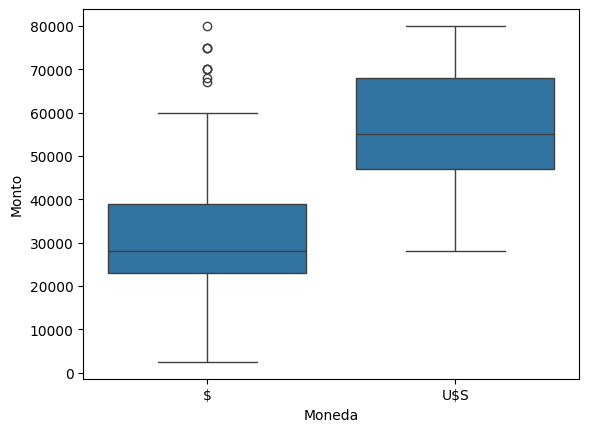

In [146]:
sns.boxplot(x='Moneda', y='Monto', data=df)

In [147]:
df_dummies = pd.get_dummies(df)


221    2497440.0
222    1873080.0
587    1381160.0
220    1248720.0
307     720000.0
         ...    
690          NaN
807          NaN
837          NaN
923          NaN
965          NaN
Name: Monto, Length: 1050, dtype: float64

In [154]:
import pandas as pd
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

# Eliminar filas con valores NaN o infinitos en la variable objetivo y
df_dummies_clean = df_dummies.dropna(subset=['Monto'], axis=0).replace([np.inf, -np.inf], np.nan).dropna(subset=['Monto'], axis=0)

# Split the data into features (X) and target variable (y)
X = df_dummies_clean.drop('Monto', axis=1)
y = df_dummies_clean['Monto']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create an XGBoost regression model
model = XGBRegressor()

# Fit the model to the training data
model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = model.predict(X_test)

# Calculate the root mean squared error
mae = mean_absolute_error(y_test, y_pred)

# Calcular MSE
mse = mean_squared_error(y_test, y_pred)

# Calcular RMSE
rmse = np.sqrt(mse)

# Calcular R^2
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"R^2: {r2}")

MAE: 15145.993601831897
MSE: 412485967.29357713
RMSE: 20309.750547300602
R^2: -0.29952202295387464


In [159]:
import numpy as np
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer

# Diccionario de modelos a evaluar
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(alpha=1.0),
    "Lasso Regression": Lasso(alpha=0.1),
    "Random Forest": RandomForestRegressor(n_estimators=100),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100),
    "Support Vector Regression": make_pipeline(StandardScaler(), SVR(C=1.0, epsilon=0.2))
}

# Función para entrenar y evaluar modelos
def train_eval_models(models, X_train, X_test, y_train, y_test):
    for name, model in models.items():
        # Entrenar el modelo
        model.fit(X_train, y_train)
        # Predecir en el conjunto de prueba
        y_pred = model.predict(X_test)
        # Calcular métricas
        mae = mean_absolute_error(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_test, y_pred)
        # Imprimir resultados
        print(f"R^2: {r2:.2f}")
        print("-" * 30)

# Llamar a la función con tus datos
# Create an imputer to fill missing values with the mean
imputer = SimpleImputer()

# Fit the imputer on the training data
imputer.fit(X_train)

# Transform the training and test data
X_train_imputed = imputer.transform(X_train)
X_test_imputed = imputer.transform(X_test)

# Train and evaluate models on imputed data
train_eval_models(models, X_train_imputed, X_test_imputed, y_train, y_test)


/home/codespace/.local/lib/python3.10/site-packages/sklearn/impute/_base.py:565: UserWarning: Skipping features without any observed values: ['Gastos Comunes']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/codespace/.local/lib/python3.10/site-packages/sklearn/impute/_base.py:565: UserWarning: Skipping features without any observed values: ['Gastos Comunes']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/codespace/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.658e+08, tolerance: 3.975e+06
  model = cd_fast.enet_coordinate_descent(


R^2: -0.98
------------------------------
R^2: -0.17
------------------------------
R^2: -0.96
------------------------------
R^2: -0.18
------------------------------
R^2: -0.30
------------------------------
R^2: -0.08
------------------------------


Root Mean Squared Error (as percentage of target range): 23.74%
